In [1]:
import pickle
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from scipy import special                 
import array
import scipy as sp
from scipy import spatial
from scipy.stats import binned_statistic



In [2]:
with open('a_lyman_limited_value.pkl', 'rb') as f:
    lyman = pickle.load(f)

In [7]:
column_den  = []
for i in lyman:
    for k in i:
        column_den.append(k[0])

In [10]:
sorted(column_den)[-1]

9.958287505668008e+21

In [91]:
#what I am going to do: get all the galaxy distance from the hprops, make a sphere tree with radius the maximum of the galaxies' radius,
#do this for every one of the lls in bins so there is no double count, fvir - the fraction of LLS that are within Rvir of any galaxy. Let’s plot fvir vs NHI. 

In [6]:
lyman_distance = []
for i in lyman:
    for z in i:
        lyman_distance.append((np.log10(z[0]),z[4]))

In [7]:
lyman_distance.sort(key = lambda row:(row[0]))

In [10]:
count = 0
for i in lyman_distance:
    if(i[0]>21):
        count +=1
count

53

In [8]:
bins = np.linspace(17,22,6)

In [9]:
bins

array([17., 18., 19., 20., 21., 22.])

In [13]:
def distance(points1, points2):
    return(np.sqrt((points1[0]-points2[0])**2 +(points1[1]-points2[1])**2+(points1[2]-points2[2])**2))

In [3]:
def nfvir(lyman_distance, bins,n):
    gals = np.loadtxt('hpropsRS.res', usecols=[5,6,7,8],unpack=1) 
    points = []
    for i,j,k in zip(gals[0],gals[1],gals[2]):
        points.append([i,j,k])
    radius_points = []
    for i in gals[3]:
        radius_points.append(i)
    percentage = [0] * (len(bins))
    #lls in rvir
    within_lls = 0 
    #total lls
    counts=0
    #bins count
    bin_counts = 1
    #one extra space
    points.append([0,0,0])
    for i in lyman_distance:
        counts +=1
        #i[0] is the column density, i[1] is the lyman location
        #less than certain density in bins
        if i[0] < bins[bin_counts]:
            points[-1] = (i[1])
            tree = spatial.KDTree(points)
            #look at what is associated
            all_nn_indices = tree.query_ball_point(points[-1],r=2.175e-01*n)
            #check fvir conditions
            conditions = False
            for k in all_nn_indices:
                if(points[k] != points[-1]):
                #see if distance in between is smaller than vir distance times by n 
                    if(distance(i[1],points[k]) < radius_points[k]*n):
                        #if true
                        #
                        conditions = True
            if conditions == True:
                within_lls += 1

        else:
            print(within_lls/counts)
            print(counts)
            percentage[bin_counts-1] = within_lls/counts
            within_lls = 0
            counts =0
            bin_counts+=1
    print(within_lls/counts)
    print(counts)            
    percentage[bin_counts-1] = within_lls/counts
    return percentage

In [4]:
def nfvir2(lyman_distance, bins,n):
    gals = np.loadtxt('hpropsRS.res', usecols=[5,6,7,8],unpack=1) 
    points = []
    for i,j,k in zip(gals[0],gals[1],gals[2]):
        points.append([i,j,k])
    radius_points = []
    for i in gals[3]:
        radius_points.append(i)
    percentage = [0] * (len(bins))
    #lls in rvir
    #total lls
    counts=0
    #bins count
    bin_counts = 1
    #one extra space
    points.append([0,0,0])
    checkout = []
    for i in lyman_distance:
        counts +=1
        #i[0] is the column density, i[1] is the lyman location
        #less than certain density in bins
        if i[0] < bins[bin_counts]:
            points[-1] = (i[1])
            tree = spatial.KDTree(points)
            #look at what is associated
            all_nn_indices = tree.query_ball_point(points[-1],r=2.175e-01*n)
            #check fvir conditions
            for k in all_nn_indices:
                if(points[k] != points[-1]):
                #see if distance in between is smaller than vir distance times by n 
                    if(distance(i[1],points[k]) < radius_points[k]*n):
                        #if true
                        checkout.append([distance(i[1],points[k]),radius_points[k],i[0]])
        else:
            percentage[bin_counts-1] = counts
            counts =0
            bin_counts+=1     
    percentage[bin_counts-1] = counts
    return percentage,checkout

In [11]:
def nfvir3(lyman_distance, bins,n):
    gals = np.loadtxt('hpropsRS.res', usecols=[5,6,7,8],unpack=1) 
    points = []
    for i,j,k in zip(gals[0],gals[1],gals[2]):
        points.append([i,j,k])
    radius_points = []
    for i in gals[3]:
        radius_points.append(i)
    #lls in rvir
    #total lls
    #bins count
    bin_counts = 1
    #one extra space
    points.append([0,0,0])
    lyman_location = []
    galaxies = []
    locations = []
    column_den = []
    for i in lyman_distance:
        #i[0] is the column density, i[1] is the lyman location
        #less than certain density in bins
        if 19<i[0] <20:
            points[-1] = (i[1])
            tree = spatial.KDTree(points)
            #look at what is associated
            all_nn_indices = tree.query_ball_point(points[-1],r=2.175e-01*n)
            #check fvir conditions
            condition = False
            for k in all_nn_indices:
                if(points[k] != points[-1]):
                #see if distance in between is smaller than vir distance times by n 
                    if(distance(i[1],points[k]) < radius_points[k]*3):
                        condition = True
                        #if true
            if condition == False:
                for z in all_nn_indices:
                    if(points[z] != points[-1]):
                        if(distance(i[1],points[z]) < radius_points[z]*4):
                            column_den.append(i[0])
                            galaxies.append([radius_points[z],0,0,0,abs(distance(i[1],points[z]))])
                            lyman_location.append(i[1])
                            locations.append([points[z][0]-i[1][0],points[z][1]-i[1][1],points[z][2]-i[1][2]])
    return galaxies,lyman_location,locations, column_den

In [10]:
import pickle as pickle
import pickle
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from scipy import special                 
import array
import scipy as sp
from scipy import spatial
from scipy.stats import binned_statistic

In [14]:
galaxies, lyman_location,locations, column_den = nfvir3(lyman_distance, bins,4)

In [16]:
lyman_location

[[24.089314528684767, 26.094516643839, 0.5298404860102579],
 [6.161516906545435, 8.899683282111907, 36.69002360431517],
 [6.161516906545435, 8.899683282111907, 36.69002360431517],
 [21.137529668302058, 7.532755350737645, 38.58886642771442],
 [22.64409175426858, 15.719192203163146, 36.809067167476215],
 [2.751541580254546, 22.206696154018875, 1.7383948119506094],
 [2.751541580254546, 22.206696154018875, 1.7383948119506094],
 [2.751541580254546, 22.206696154018875, 1.7383948119506094],
 [6.10937877562292, 8.901133755906985, 36.63465071988898],
 [6.10937877562292, 8.901133755906985, 36.63465071988898],
 [6.10937877562292, 8.901133755906985, 36.63465071988898],
 [3.4082706409773316, 9.917154030085243, 28.877179619252473],
 [22.935182443985617, 8.685053280177112, 24.846124324102256],
 [22.935182443985617, 8.685053280177112, 24.846124324102256],
 [39.943693928858735, 39.01076666655493, 25.70554752200273],
 [23.359232494347324, 32.38249340480462, 20.130180023157973],
 [17.36851482541427, 33.9

In [17]:
data = []
data.append(lyman_location)
data.append(galaxies)
data.append(locations)

In [18]:
with open('data_2.pkl', 'wb') as f:
    pickle.dump(data, f, protocol=pickle.HIGHEST_PROTOCOL)

In [39]:

with open('a_nfvir1_big_bins.pkl', 'rb') as f:
    percentage = pickle.load(f)
with open('a_nfvir2_big_bins.pkl', 'rb') as f:
    percentage2 = pickle.load(f)
with open('a_nfvir3_big_bins.pkl', 'rb') as f:
    percentage3 = pickle.load(f)

In [40]:
percentage = percentage[0:5]
percentage2 = percentage2[0:5]
percentage3 = percentage3[0:5]

In [41]:
x = np.linspace(17,21,5)

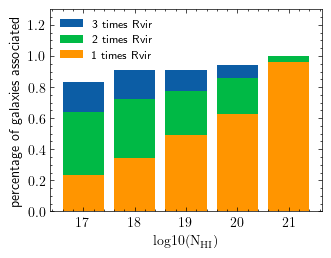

In [42]:
#17 is not the whole thing
with plt.style.context('science','notebook'):
    plt.bar(x,percentage3,label = "3 times Rvir")
    plt.bar(x,percentage2,label = "2 times Rvir")
    plt.bar(x,percentage,label = "1 times Rvir")
    plt.xlabel("$\mathrm{log10(N_{HI})}$",fontsize = 10)
    plt.ylabel("percentage of galaxies associated",fontsize =10)
    plt.ylim(0,1.3)
    plt.legend(fontsize = 8)
    plt.savefig("a_fvir.pdf")

In [43]:
with open('counts_dex_bin.pkl', 'rb') as f:
    percentage = pickle.load(f)
with open('distance.pkl', 'rb') as f:
    checkout = pickle.load(f)

In [44]:
checkout

[[0.025342641153281976, 0.01435, 17.208062472097048],
 [0.05067217607675307, 0.01731, 17.210030498509454],
 [0.02623860119331967, 0.01183, 17.210030498509454],
 [0.043063837468240135, 0.04012, 17.210263833866488],
 [0.07282137988248193, 0.02579, 17.210263833866488],
 [0.01611913265912137, 0.008965, 17.21029593589265],
 [0.036201817494904885, 0.02466, 17.211761342951554],
 [0.10873209336815948, 0.05182, 17.215249528315862],
 [0.015914902476561483, 0.009785, 17.216700780925404],
 [0.033466979926047524, 0.02789, 17.217430190317373],
 [0.08027548584161322, 0.04455, 17.21761436291899],
 [0.07253676830346753, 0.05149, 17.218987319432927],
 [0.03865374961338188, 0.01387, 17.218987319432927],
 [0.09301388696456706, 0.03516, 17.218987319432927],
 [0.09291595101875191, 0.03645, 17.220056892430218],
 [0.044255726108422724, 0.01808, 17.22078739370283],
 [0.022914312083540053, 0.01739, 17.22078739370283],
 [0.07330489385145306, 0.04668, 17.220950233608075],
 [0.1310491230306001, 0.0594, 17.22095023

In [45]:
percentage

[1,
 1,
 89,
 82,
 80,
 63,
 60,
 47,
 41,
 26,
 51,
 27,
 23,
 33,
 28,
 24,
 22,
 18,
 21,
 16,
 17,
 26,
 23,
 19,
 24,
 24,
 21,
 32,
 20,
 32,
 38,
 33,
 32,
 20,
 20,
 24,
 23,
 17,
 11,
 12,
 9,
 14,
 5,
 4,
 6,
 1,
 6,
 4,
 2,
 1,
 0]

In [46]:
len(bins)

6

In [47]:
def plot_function(n):
    temp_counts = 0
    bin_counts = 1
    density = 0
    previous = 0
    temp_percentage = []
    for i in range(1,len(checkout)):
        if(checkout[i][2] > bins[bin_counts]):
            if(percentage[bin_counts-1] == 0):
                temp_percentage.append(0)
            else:
                temp_percentage.append(temp_counts/percentage[bin_counts-1])
            bin_counts +=1
            temp_counts = 0
        if(checkout[i][0] <= checkout[i][1]*n):
            #count less than before here, because it doesn't look at what if the later one works
            if(previous != checkout[i][2]):
                temp_counts += 1
                previous = checkout[i][2]

    return temp_percentage


ValueError: x and y must have same first dimension, but have shapes (49,) and (4,)

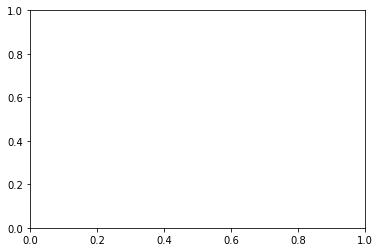

In [48]:
temp_percentage =plot_function(1)
temp_percentage2 = plot_function(2)
temp_percentage3 =plot_function(3)
x = np.linspace(17,22,49)
plt.plot(x,np.subtract(1,temp_percentage),label = "fvir_1",c="red")
plt.ylabel("1-percentage associated",size=15)
plt.xlabel("column density",size=15)
plt.title("fvir_1",size=15)
plt.xlim(17.2,22)


In [ ]:
def fix_bins(temp_percentage):
    bins_5_1 = []
    
    for i in range(0,48,6):
        average =0
        for k in range(0,6):
            average += temp_percentage[i+k]
        bins_5_1.append(average/6)
    return bins_5_1


In [ ]:
bins_5_1 = fix_bins(temp_percentage)
bins_5_2 = fix_bins(temp_percentage2)
bins_5_3 = fix_bins(temp_percentage3)

In [ ]:
print(bins_5_1)

[0.13813876491493646, 0.2942510300048178, 0.3802099671664889, 0.35344394681536295, 0.5157738095238096, 0.5844962785752259, 0.6911006607298167, 0.6611111111111111]


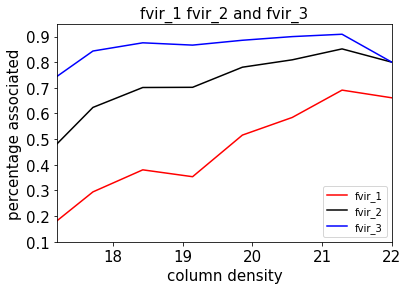

In [ ]:
x = np.linspace(17,22,8)
plt.plot(x,bins_5_1,label = "fvir_1",c="red")
plt.plot(x,bins_5_2,label = "fvir_2",c="black")
plt.plot(x,bins_5_3,label = "fvir_3",c="blue")
plt.xticks(size=15)
plt.yticks(size=15)
plt.ylabel("percentage associated",size=15)
plt.xlabel("column density",size=15)
plt.title("fvir_1 fvir_2 and fvir_3",size=15)
plt.xlim(17.2,22)
plt.legend()